<a href="https://colab.research.google.com/github/tllongdev/Facial-Emotion-Detection/blob/main/TimothyLeeLong_Facial_Emotion_Detection_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Emotion Detection**

## **Problem Definition**

**The context:** Automating the detecting the emotion of a person through image data has increasing purpose in modern sociaty. Improving the lives of individuals though the use of technology is an obvious use case. Is someone upset? Maybe your mobile devide can help cheer you up. Suprised? Provide insight... Happy? Keep it going.. or maybe your emotional state can be monitored to provide better advertizing. Maybe to create a data set for analytics over an extended period of time. The posibilities are endless.<br>
**The objectives:** Develop a machine learning model that can detect the  emotion a person is expressing from a photo of their face. The scope of this project is limited to detection of four emotions: [happy, sad, neutral, surprised]. Photos will be read as input by the machine learning model and the objective is to detect the emotion expressed by the person in the photo with the greatest accuracy by comparing transfer learning feature extraction vs fine tuning of CNN models .<br>



## **About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# GPU Hardware Accelerator
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Found GPU at: /device:GPU:0


### **Let us load and unzip the data**

In [ ]:
# Copy data file from Google Drive into Colab
!cp /content/drive/MyDrive/Facial_emotion_images.zip /content/Facial_emotion_images.zip

In [ ]:
# Storing the path of the data file copied into Colab
path = '/content/Facial_emotion_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

picture_size = 48
folder_path = "Facial_emotion_images/"

## **Visualizing our Classes**


In [ ]:
# Function returns plot of images for given expression
def show_images_for_expression(expression):
  plt.figure(figsize= (8,8))
  for i in range(1, 10, 1):
      plt.subplot(3, 3, i)
      img = load_img(folder_path + "train/" + expression + "/" +
                     os.listdir(folder_path + "train/" + expression)[i],
                     target_size = (picture_size, picture_size))
      plt.imshow(img)
  plt.show()

### **Happy**

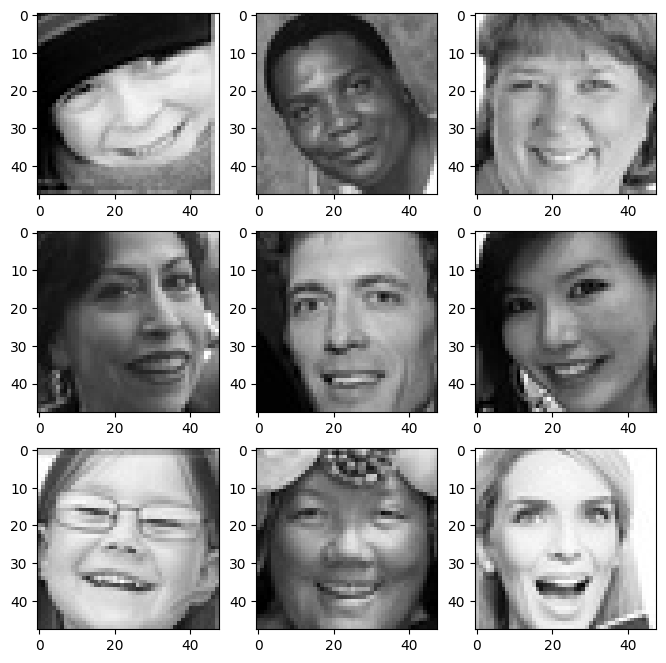

In [ ]:
show_images_for_expression('happy')

**Observations and Insights:**
- raised cheek muscle on one or both side(s)
- edges of mouth are above the center of the bottom lip on horizontal mouth axis
- bottom eye lids raised
- teeth may be visible

### **Sad**

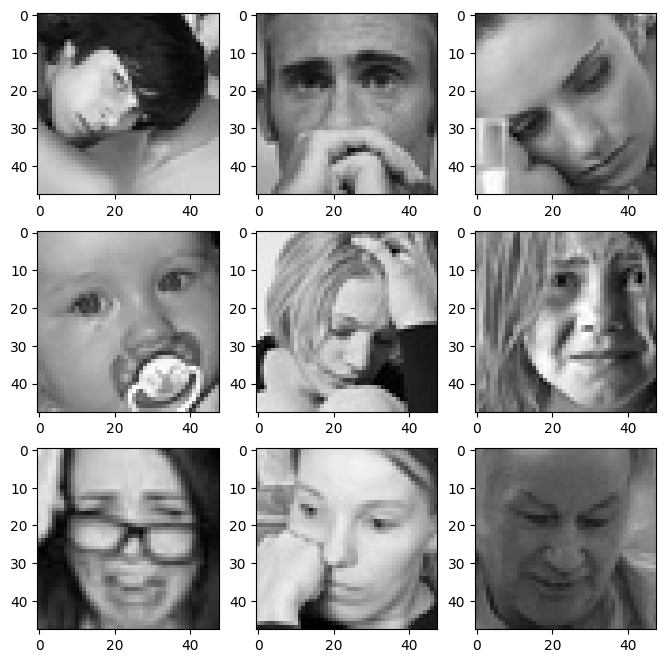

In [ ]:
show_images_for_expression('sad')

**Observations and Insights:**
- edges of mouth may be below or level with the center of the bottom lip on horizontal mouth axis
- muscles at center of brow flexed an eye brows angled down toward edge of face or muscles at center of brow not flexed an eye brows angled up toward edge of face  
- images seem to be of questionable as some samples look neutral or even happy

### **Neutral**

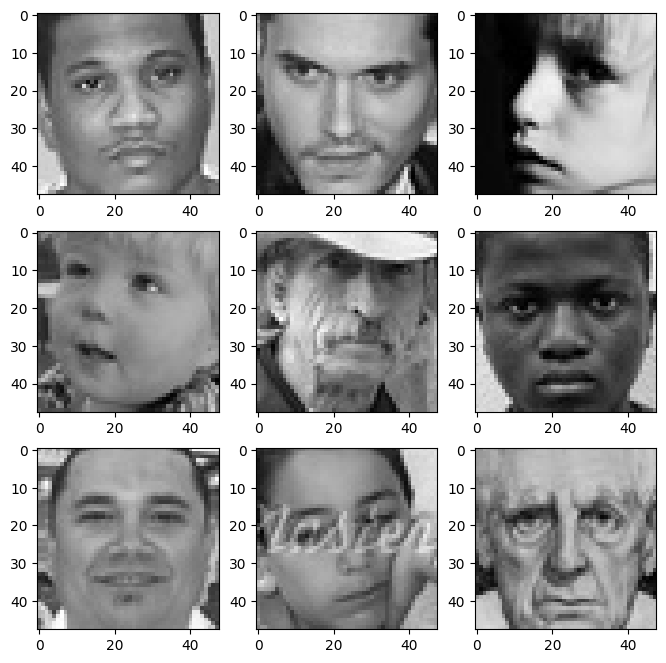

In [ ]:
show_images_for_expression('neutral')

**Observations and Insights:**
- neutral images are ambiguous
- sample images seem to be questionable as some samples look sad or happy or even suprised

### **Surprised**

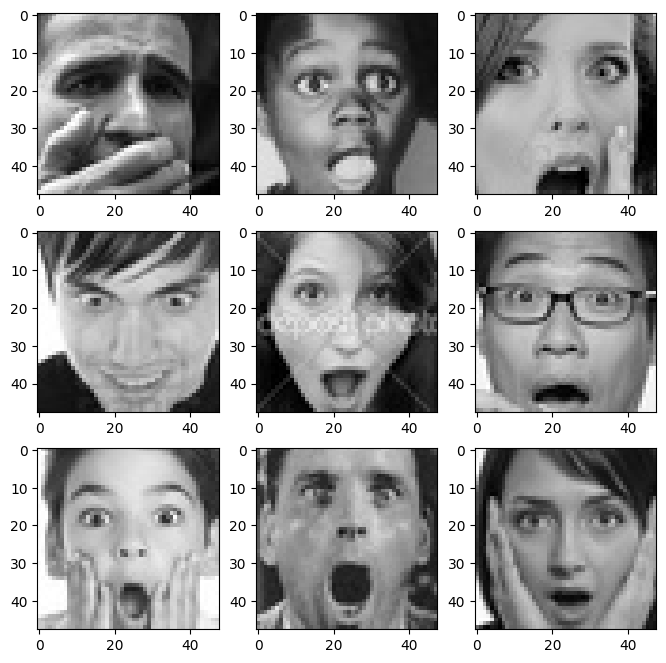

In [ ]:
show_images_for_expression('surprise')

**Observations and Insights:**
- mouth usually open
- eye brows raised
- eyes open wide

## **Checking Distribution of Classes**

Number of images in the class 'Happy':    3976
Number of images in the class 'Sad':    3982
Number of images in the class 'Neutral':    3978
Number of images in the class 'Surprise':    3173


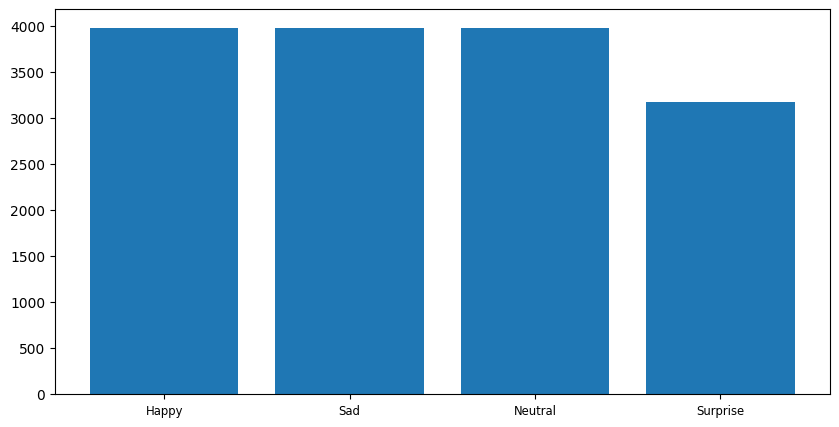

In [ ]:
# Getting count of images in each folder within our training path
num_happy = len(os.listdir(folder_path + "train/happy"))
print("Number of images in the class 'Happy':   ", num_happy)

num_sad = len(os.listdir(folder_path + "train/sad"))
print("Number of images in the class 'Sad':   ", num_sad)

num_neutral = len(os.listdir(folder_path + "train/neutral"))
print("Number of images in the class 'Neutral':   ", num_neutral)

num_surprise = len(os.listdir(folder_path + "train/surprise"))
print("Number of images in the class 'Surprise':   ", num_surprise)

# Code to plot histogram
plt.figure(figsize = (10, 5))

data = {'Happy': num_happy, 'Sad': num_sad, 'Neutral': num_neutral, 'Surprise' : num_surprise}

df = pd.Series(data)

plt.bar(range(len(df)), df.values, align = 'center')

plt.xticks(range(len(df)), df.index.values, size = 'small')

plt.show()

**Observations and Insights:**
- Suprise class has significantly less images in training data set
- todo: create bar plots for validation and train and observe each

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

In [ ]:
# create data loader function

def create_data_loader(data_set_name, color_mode = 'grayscale', batch_size  = 32, img_size = 48,
                       class_mode = 'categorical', shuffle = True, folder_path = folder_path):

  datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

  return datagen_train.flow_from_directory(folder_path + data_set_name,
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode,
                                              batch_size = batch_size,
                                              class_mode = class_mode,
                                              shuffle = shuffle)

# create data loaders for data sets
train_set = create_data_loader('train')
validation_set = create_data_loader('validation')
test_set = create_data_loader('test', shuffle = False, batch_size  = 128)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **Model Building**

### **Creating and Compiling the Base Neural Network**

In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  # Initializing a Sequential Model
  model1 = Sequential()

  # Add the first Convolutional block
  model1.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', input_shape = (48, 48, 1)))
  model1.add(MaxPooling2D(pool_size = 2))
  model1.add(Dropout(0.2))

  # Add the second Convolutional block
  model1.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
  model1.add(MaxPooling2D(pool_size = 2))
  model1.add(Dropout(0.2))

  # Add the third Convolutional block
  model1.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
  model1.add(MaxPooling2D(pool_size = 2))
  model1.add(Dropout(0.2))

  # Add the Flatten layer
  model1.add(Flatten())

  # Add the first Dense layer
  model1.add(Dense(512, activation = 'relu'))
  model1.add(Dropout(0.4))

  # Add the Final layer
  model1.add(Dense(4, activation = 'softmax'))

  # Compile
  model1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 32)       

### **Training the Model**

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early_stopping = EarlyStopping(monitor = 'val_loss',
#                           min_delta = 0,
#                           patience = 3,
#                           verbose = 1,
#                           restore_best_weights = True
#                           )

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Fit
history_m1 = model1.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks =  callbacks_list)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.3244 - accuracy: 0.3552
Epoch 1: val_accuracy improved from -inf to 0.46735, saving model to ./model1.h5
473/473 [==============================] - 21s 40ms/step - loss: 1.3244 - accuracy: 0.3552 - val_loss: 1.2146 - val_accuracy: 0.4673 - lr: 0.0010
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 1.1993 - accuracy: 0.4642
Epoch 2: val_accuracy improved from 0.46735 to 0.51316, saving model to ./model1.h5
473/473 [==============================] - 18s 39ms/step - loss: 1.1993 - accuracy: 0.4642 - val_loss: 1.1309 - val_accuracy: 0.5132 - lr: 0.0010
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 1.1292 - accuracy: 0.5030
Epoch 3: val_accuracy improved from 0.51316 to 0.56219, saving model to ./model1.h5
473/473 [==============================] - 18s 39ms/step - loss: 1.1294 - accuracy: 0.5029 - val_loss: 1.0604 - val_accuracy: 0.5622 - lr: 0.0010
Epoch 4/20
472/473 [=====

### **Evaluating the Model on the Test Set**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        32
           1       0.56      0.62      0.59        32
           2       0.53      0.50      0.52        32
           3       0.93      0.78      0.85        32

    accuracy                           0.67       128
   macro avg       0.68      0.67      0.67       128
weighted avg       0.68      0.67      0.67       128



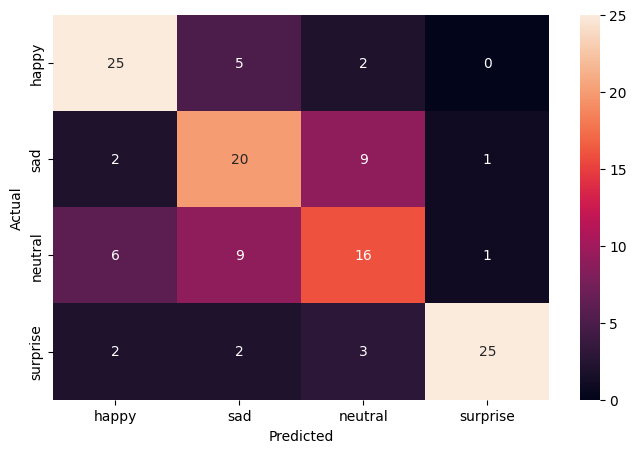

In [ ]:
model1_data_set = create_data_loader('test', batch_size  = 128, shuffle = False)

data_images, data_labels = next(model1_data_set)

# Make prediction on the test data
test_pred = model1.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- best performance on suprise, happy respectively
- difference between sad and neutral are least discernable to the model


### **Creating the second Convolutional Neural Network**

In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  # Create sequential model
  model2 = Sequential()

  # Add the first Convolutional block
  model2.add(Conv2D(filters = 256, kernel_size = 2, padding = 'same', input_shape = (48, 48, 1), activation = 'relu'))
  model2.add(BatchNormalization())
  model2.add(LeakyReLU(alpha=0.1))
  model2.add(MaxPooling2D(pool_size = 2))

  # Add the second Convolutional block
  model2.add(Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'))
  model2.add(BatchNormalization())
  model2.add(LeakyReLU(alpha=0.1))
  model2.add(MaxPooling2D(pool_size = 2))

  # Add the third Convolutional block
  model2.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
  model2.add(BatchNormalization())
  model2.add(LeakyReLU(alpha=0.1))
  model2.add(MaxPooling2D(pool_size = 2))

  # Add the fourth Convolutional block
  model2.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
  model2.add(BatchNormalization())
  model2.add(LeakyReLU(alpha=0.1))
  model2.add(MaxPooling2D(pool_size = 2))

  # Add the Flatten layer
  model2.add(Flatten())

  # Adding the Dense layers
  model2.add(Dense(512, activation='relu'))
  model2.add(Dense(128, activation='relu'))

  # Add the Final layer
  model2.add(Dense(4, activation = 'softmax'))

  # Compile
  model2.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

### **Training the Model**

In [ ]:
# keras callbacks config

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

# early_stopping = EarlyStopping(monitor = 'val_loss',
#                           min_delta = 0,
#                           patience = 3,
#                           verbose = 1,
#                           restore_best_weights = True
#                           )

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]
# callbacks_list = [early_stopping, checkpoint]

epochs = 20

In [ ]:
# Fit
history_m2 = model2.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)

Epoch 1/20
472/473 [============================>.] - ETA: 0s - loss: 0.6439 - accuracy: 0.7326
Epoch 1: val_accuracy improved from -inf to 0.70444, saving model to ./model2.h5
473/473 [==============================] - 19s 39ms/step - loss: 0.6438 - accuracy: 0.7327 - val_loss: 0.7297 - val_accuracy: 0.7044 - lr: 2.0000e-04
Epoch 2/20
472/473 [============================>.] - ETA: 0s - loss: 0.6274 - accuracy: 0.7407
Epoch 2: val_accuracy improved from 0.70444 to 0.70886, saving model to ./model2.h5
473/473 [==============================] - 18s 39ms/step - loss: 0.6274 - accuracy: 0.7408 - val_loss: 0.7384 - val_accuracy: 0.7089 - lr: 2.0000e-04
Epoch 3/20
472/473 [============================>.] - ETA: 0s - loss: 0.6185 - accuracy: 0.7435
Epoch 3: val_accuracy improved from 0.70886 to 0.71750, saving model to ./model2.h5
473/473 [==============================] - 18s 39ms/step - loss: 0.6187 - accuracy: 0.7434 - val_loss: 0.7164 - val_accuracy: 0.7175 - lr: 2.0000e-04
Epoch 4/20
47

### **Evaluating the Model on the Test Set**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.84      0.73        32
           1       0.50      0.53      0.52        32
           2       0.56      0.44      0.49        32
           3       0.89      0.75      0.81        32

    accuracy                           0.64       128
   macro avg       0.65      0.64      0.64       128
weighted avg       0.65      0.64      0.64       128



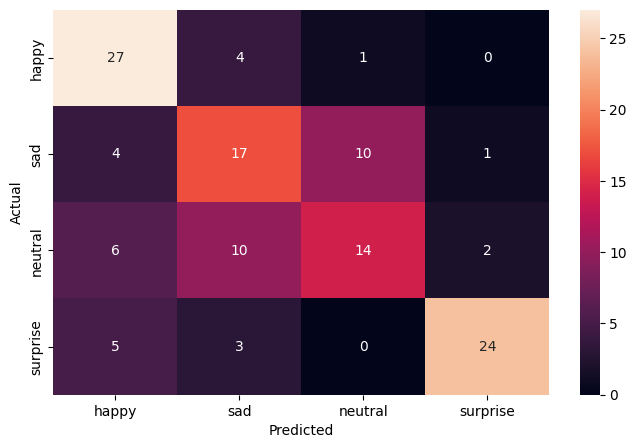

In [ ]:
model2_data_set = create_data_loader('test', batch_size  = 128, shuffle = False)

data_images, data_labels = next(model2_data_set)

# Make prediction on the test data
test_pred = model2.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- Adding more blocks and experimenting with more fine tuning of parameters has lead to greater accuracy than out first model
- grayscale allows better performance

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [ ]:
# vggmodel_data_set = create_data_loader('validation', batch_size  = 4977, color_mode = 'rgb', shuffle = False)
# create data loaders for data sets
train_set = create_data_loader('train', color_mode = 'rgb')
validation_set = create_data_loader('validation', color_mode = 'rgb')
test_set = create_data_loader('test', shuffle = False, batch_size  = 128, color_mode = 'rgb')

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Model Building**

In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  transfer_layer = vgg.get_layer('block3_pool')
  vgg.trainable = False

  # Flatten the output from the 3rd block of the VGG16 model
  x = Flatten()(transfer_layer.output)

  # Adding a Dense layer with 256 neurons
  x = Dense(256, activation = 'relu')(x)

  # Add a Dense Layer with 128 neurons
  x = Dense(128, activation = 'relu')(x)

  # Add a DropOut layer with Drop out ratio of 0.3
  x = Dropout(0.3)(x)

  # Add a Dense Layer with 64 neurons
  x = Dense(64, activation = 'relu')(x)

  # Add a Batch Normalization layer
  x = BatchNormalization()(x)

  # Adding the final dense layer with 4 neurons and use 'softmax' activation
  pred = Dense(4, activation='softmax')(x)

  vggmodel = Model(vgg.input, pred) # Initializing the model

  # Compile
  vggmodel.compile(optimizer=RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

vggmodel.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

### **Training the VGG16 Model**

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Fit
history = vggmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)

Epoch 1/20
472/473 [============================>.] - ETA: 0s - loss: 1.1736 - accuracy: 0.4870
Epoch 1: val_accuracy improved from -inf to 0.54832, saving model to ./vggmodel.h5
473/473 [==============================] - 36s 55ms/step - loss: 1.1733 - accuracy: 0.4873 - val_loss: 1.1064 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 2/20
473/473 [==============================] - ETA: 0s - loss: 0.9531 - accuracy: 0.5963
Epoch 2: val_accuracy improved from 0.54832 to 0.57143, saving model to ./vggmodel.h5
473/473 [==============================] - 26s 54ms/step - loss: 0.9531 - accuracy: 0.5963 - val_loss: 1.0214 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.6286
Epoch 3: val_accuracy did not improve from 0.57143
473/473 [==============================] - 26s 55ms/step - loss: 0.8867 - accuracy: 0.6286 - val_loss: 1.8418 - val_accuracy: 0.3203 - lr: 0.0010
Epoch 4/20
472/473 [============================>.] - 

### **Evaluating the VGG16 model**

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1825
           1       0.60      0.63      0.61      1216
           2       0.61      0.62      0.62      1139
           3       0.79      0.79      0.79       797

    accuracy                           0.71      4977
   macro avg       0.70      0.70      0.70      4977
weighted avg       0.71      0.71      0.71      4977



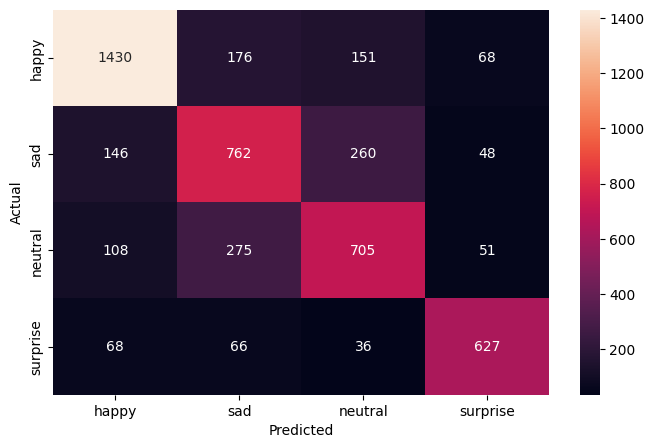

In [ ]:
vggmodel_data_set = create_data_loader('validation', batch_size  = 4977, color_mode = 'rgb', shuffle = False)

data_images, data_labels = next(vggmodel_data_set)

# Make prediction on the test data
test_pred = vggmodel.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**

- training performance increased through the first 7 epochs then plateaued  
- training accuracy consistently improved until the last few epochs
- accuracy 71%

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

## **ResNet V2 Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                          

### **Model Building**

In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  transfer_layer_Resnet = Resnet.get_layer('conv3_block3_add')

  Resnet.trainable=False

  # Flatten the output from the ResNet model
  x = Flatten()(transfer_layer_Resnet.output)

  # Add a Dense layer with 128 neurons
  x = Dense(128, activation = 'relu')(x)

  # Add a Batch Normalization layer
  x = BatchNormalization()(x)

  # Add a Dense Layer with 64 neurons
  x = Dense(64, activation = 'relu')(x)

  ## Add a Batch Normalization layer
  x = BatchNormalization()(x)

  # Add a DropOut layer with Drop out ratio of 0.3
  x = Dropout(0.3)(x)

  # Add a Dense Layer with 32 neurons
  x = Dense(32, activation = 'relu')(x)

  # Add a Batch Normalization layer
  x = BatchNormalization()(x)

  # Add the final dense layer with 4 neurons and use a 'softmax' activation
  pred = Dense(4, activation = 'softmax')(x)

  resnetmodel = Model(Resnet.input, pred) # Initializing the model

  resnetmodel.compile(optimizer=RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

resnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

### **Training the Model**

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:
# Fit
history_resnet = resnetmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)

Epoch 1/20
473/473 [==============================] - ETA: 0s - loss: 1.3320 - accuracy: 0.4196
Epoch 1: val_accuracy improved from -inf to 0.32811, saving model to ./Resnetmodel.h5
473/473 [==============================] - 39s 59ms/step - loss: 1.3320 - accuracy: 0.4196 - val_loss: 2.2282 - val_accuracy: 0.3281 - lr: 1.0000e-04
Epoch 2/20
473/473 [==============================] - ETA: 0s - loss: 1.1788 - accuracy: 0.4826
Epoch 2: val_accuracy did not improve from 0.32811
473/473 [==============================] - 27s 57ms/step - loss: 1.1788 - accuracy: 0.4826 - val_loss: 2.1647 - val_accuracy: 0.2733 - lr: 1.0000e-04
Epoch 3/20
473/473 [==============================] - ETA: 0s - loss: 1.1348 - accuracy: 0.5013
Epoch 3: val_accuracy improved from 0.32811 to 0.47519, saving model to ./Resnetmodel.h5
473/473 [==============================] - 27s 57ms/step - loss: 1.1348 - accuracy: 0.5013 - val_loss: 1.4055 - val_accuracy: 0.4752 - lr: 1.0000e-04
Epoch 4/20
473/473 [================

### **Evaluating the ResNet Model**

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      1825
           1       0.57      0.41      0.47      1216
           2       0.48      0.55      0.51      1139
           3       0.77      0.61      0.68       797

    accuracy                           0.61      4977
   macro avg       0.62      0.59      0.59      4977
weighted avg       0.61      0.61      0.60      4977



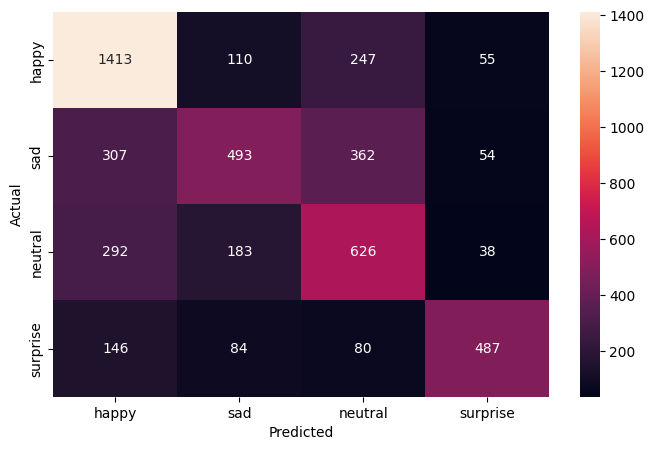

In [ ]:
resnetmodel_data_set = create_data_loader('validation', batch_size  = 4977, color_mode = 'rgb', shuffle = False)

data_images, data_labels = next(resnetmodel_data_set)

# Make prediction on the test data
test_pred = resnetmodel.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- after stepping back through transfer layers and a lot of tinkering with callback settings, current accuracy is about 61%
- lower transfer layer, less epochs, stop early callback patience set higher seems to be a sweet spot


**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

In [ ]:
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 3s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
  EfficientNet.trainable = False

  x = Flatten()(transfer_layer_EfficientNet.output)

  # Add a Dense Layer with 512 neurons
  x = Dense(512, activation = 'sigmoid')(x)

  # BatchNormalization layer
  x = BatchNormalization()(x)

  # Add a Dense Layer with 256 neurons
  x = Dense(256, activation = 'sigmoid')(x)

  # Add a Dense Layer with 128 neurons
  x = Dense(128, activation = 'sigmoid')(x)

  # Add a BatchNormalization layer
  x = BatchNormalization()(x)

  # Add a Dense Layer with 64 neurons
  x = Dense(64, activation = 'sigmoid')(x)

  # Add final Dense layer with 4 neurons and softmax activation function.
  pred = Dense(4, activation = 'softmax')(x)

  Efficientnetmodel = Model(EfficientNet.input, pred)

  # Compile
  Efficientnetmodel.compile(optimizer=RMSprop(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

Efficientnetmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                                                                                            

### **Training the Model**

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 25

In [ ]:
# Fit
history_effnet = Efficientnetmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)


Epoch 1/25
472/473 [============================>.] - ETA: 0s - loss: 1.3846 - accuracy: 0.2699
Epoch 1: val_accuracy improved from -inf to 0.36669, saving model to ./Efficientnetmodel.h5
473/473 [==============================] - 28s 59ms/step - loss: 1.3847 - accuracy: 0.2697 - val_loss: 1.3610 - val_accuracy: 0.3667 - lr: 3.0000e-04
Epoch 2/25
473/473 [==============================] - ETA: 0s - loss: 1.3854 - accuracy: 0.2593
Epoch 2: val_accuracy did not improve from 0.36669
473/473 [==============================] - 28s 58ms/step - loss: 1.3854 - accuracy: 0.2593 - val_loss: 1.3713 - val_accuracy: 0.2443 - lr: 3.0000e-04
Epoch 3/25
473/473 [==============================] - ETA: 0s - loss: 1.3841 - accuracy: 0.2658
Epoch 3: val_accuracy did not improve from 0.36669
473/473 [==============================] - 27s 58ms/step - loss: 1.3841 - accuracy: 0.2658 - val_loss: 1.3685 - val_accuracy: 0.3623 - lr: 3.0000e-04
Epoch 4/25
472/473 [============================>.] - ETA: 0s - loss

### **Evaluating the EfficientnetNet Model**

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.37      0.88      0.52      1825
           1       0.00      0.00      0.00      1216
           2       0.34      0.18      0.24      1139
           3       0.00      0.00      0.00       797

    accuracy                           0.36      4977
   macro avg       0.18      0.27      0.19      4977
weighted avg       0.21      0.36      0.24      4977



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


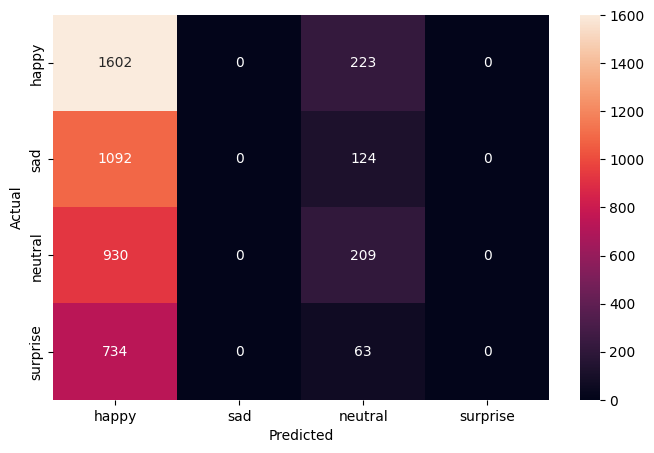

In [ ]:
Efficientnetmodel_data_set = create_data_loader('validation', batch_size  = 4977, color_mode = 'rgb', shuffle = False)

data_images, data_labels = next(Efficientnetmodel_data_set)

# Make prediction on the test data
test_pred = Efficientnetmodel.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- After trying a few different architectural configurations, I have not had much success with EffNet.

**Think About It:**

* Transfer Learning Architectures did not perform as well as the CNN models trained with grayscale images? . Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

## **Building a Complex Neural Network Architecture**

### **Create Data Loaders**

In [ ]:
# create data loaders for data sets
train_set = create_data_loader('train')
validation_set = create_data_loader('validation')
test_set = create_data_loader('test', shuffle = False, batch_size  = 128)

### **Model Building**


In [ ]:
# Create and Compile on GPU
with tf.device(device_name):
  no_of_classes = 4

  model3 = Sequential()

  # Add 1st CNN Block
  model3.add(Conv2D(filters = 96, kernel_size = 4, padding = 'same',
                    input_shape = (48, 48, 1), activation = 'relu')) #Applies the rectified linear unit activation function.
  model3.add(BatchNormalization()) # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. Importantly, batch normalization works differently during training and during inference.
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D(pool_size = 2)) # pooling layer - reduce the dimensions of the hidden layer by combining the outputs of neuron clusters at the previous layer into a single neuron in the next layer
  model3.add(Dropout(0.2)) # Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

  # Add 2nd CNN Block
  model3.add(Conv2D(filters = 192, kernel_size = 4, padding = 'same',
                    input_shape = (48, 48, 1), activation = 'relu'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D(pool_size = 2))
  model3.add(Dropout(0.2))

  # Add 3rd CNN Block
  model3.add(Conv2D(filters = 768, kernel_size = 4, padding = 'same',
                    input_shape = (48, 48, 1), activation = 'relu'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D(pool_size = 2))
  model3.add(Dropout(0.2))

  # Add 4th CNN Block
  model3.add(Conv2D(filters = 512, kernel_size = 4, padding = 'same',
                    input_shape = (48, 48, 1), activation = 'relu'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D(pool_size = 2))
  model3.add(Dropout(0.2))

  # Add 5th CNN Block
  model3.add(Conv2D(filters = 192, kernel_size = 4, padding = 'same',
                    input_shape = (48, 48, 1), activation = 'relu'))
  model3.add(BatchNormalization())
  model3.add(LeakyReLU(alpha=0.1))
  model3.add(MaxPooling2D(pool_size = 2))
  model3.add(Dropout(0.2))

  # Add flattening layer
  model3.add(Flatten())

  # First fully connected layer
  model3.add(Dense(256))
  model3.add(BatchNormalization())
  model3.add(ReLU())
  model3.add(Dropout(0.2))

  # Second fully connected layer
  model3.add(Dense(512))
  model3.add(BatchNormalization())
  model3.add(ReLU())
  model3.add(Dropout(0.2))

  # Final layer
  model3.add(Dense(no_of_classes, activation = 'softmax')) # Softmax converts a vector of values to a probability distribution.

  # Compile
  model3.compile(optimizer=Adam(0.0002), loss='categorical_crossentropy', metrics=['accuracy'])


### **Training the Model**

In [ ]:
# callbacks
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

epochs = 50

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 0.00001 , model = 'auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True
                          )

callbacks = [checkpoint, reduce_lr]

In [ ]:
# Fit
history_m3 = model3.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks)

Epoch 1/50
472/473 [============================>.] - ETA: 0s - loss: 1.5403 - accuracy: 0.2770
Epoch 1: saving model to model3.h5
473/473 [==============================] - 25s 40ms/step - loss: 1.5398 - accuracy: 0.2772 - val_loss: 1.3787 - val_accuracy: 0.3667 - lr: 2.0000e-04
Epoch 2/50
472/473 [============================>.] - ETA: 0s - loss: 1.3639 - accuracy: 0.3564
Epoch 2: saving model to model3.h5
473/473 [==============================] - 18s 39ms/step - loss: 1.3638 - accuracy: 0.3566 - val_loss: 1.2063 - val_accuracy: 0.4276 - lr: 2.0000e-04
Epoch 3/50
472/473 [============================>.] - ETA: 0s - loss: 1.2327 - accuracy: 0.4365
Epoch 3: saving model to model3.h5
473/473 [==============================] - 19s 39ms/step - loss: 1.2328 - accuracy: 0.4366 - val_loss: 1.1674 - val_accuracy: 0.4655 - lr: 2.0000e-04
Epoch 4/50
472/473 [============================>.] - ETA: 0s - loss: 1.1030 - accuracy: 0.5053
Epoch 4: saving model to model3.h5
473/473 [=================

### **Evaluating the Model on Test Set**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.74      0.72      0.73        32
           2       0.69      0.75      0.72        32
           3       0.94      0.91      0.92        32

    accuracy                           0.81       128
   macro avg       0.82      0.81      0.81       128
weighted avg       0.82      0.81      0.81       128



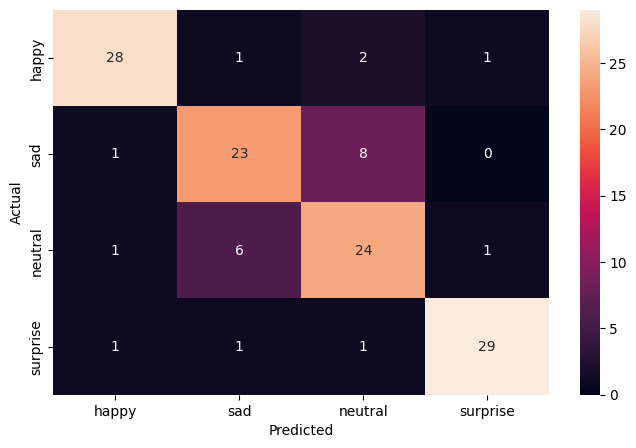

In [ ]:
model3_data_set = create_data_loader('test', batch_size  = 128, shuffle = False)

data_images, data_labels = next(model3_data_set)

# Make prediction on the test data
test_pred = model3.predict(data_images)
test_pred = np.argmax(test_pred, axis = 1)

# Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(data_labels, axis = 1)

# classification report
print(classification_report(y_test, test_pred))

# heatmap
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize = (8, 5))
heatmap_labels = ['happy', 'sad', 'neutral', 'surprise']
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = heatmap_labels, yticklabels = heatmap_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:**
- This CNN has an accuracy of 82% after fine tuning. Setting kernal size to 4 and experimenting with various filter settings on convolutional layers lead to improvements. Five blocks followed by a flattening layer and two connected layers and fine tuning has lead to our most accurate model and the proposed final solution.

## **Conclusion:**
Parcing the emotional state of a person from an image has proven to be a complex and interesting problem to solve with machine learning. The comparison in performance between pre-trained and improvised networks has demonstrated an advantage to building on-the-spot robust CNNs. Transfer learning networks do have advantages when deployed toward their intended use case, but we observed that when the image data input does not exactly match what is required, a ground-up CNN with more configurability can provide greater accuracy.   

### **Insights**

### **Refined insights**:
- Neutral and Sad have similar features leading to the greatest error for all models
- Training data for Neutral and Sad may have introduced undesired bias
- experimenting with different parameter configurations lead to greater accuracy
- Greater no. of epochs with appropriate early_stopping callback param value may lead to greater accuracy
- using cloud GPU (or faster processing) to build and compile model leads to more time for research and potentially better outcome

### **Comparison of various techniques and their relative performance**:
- The final solution being the 3rd CNN performed the best. Pre-trained models presented limitations in comparison. Further scope for optimization could include more blocks and fine tuning of CNN 3 or experimenting with other transfer learning options.  

### **Proposal for the final solution design**:
- Our third, and most complex, fine-tuned CNN delivered the best results with 81% accuracy in classifying facial emotion present in photos.  Creating a custom, robust CNN allows us the granularity of fine tuning to reach accuracy that was not achievable using transfer learning from pretrained models and less complex CNNs. The final proposed solution is  implementing a ground-up custom CNN with a complex architecture and fine-tuned parameters.

### **Executive Summary**:
- Important Findings
 - Distinguishing between Neutral and Sad presented the most difficulty for the model as these emotions seem to have the most feature cross-over.
 - Multiple blocks followed by a flattening layer, fully connected layers, and fine tuning of parameters like kernel size lead to best outcome
 - Compiling and Building on cloud GPUs significantly increased notebook execution speed
- Model Specs
 - 5 CNN Blocks
  - Convolutional layer
   - Kernel size 4
  - Batch Normalization
  - Pooling Layer
  - Flattening Layer
 - 2 Fully Connected Layers
